In [20]:
import binary_classifier as bc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sqlalchemy
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn import model_selection
from scrape import get_teams

#to ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

In [2]:
#conn = sqlcmds.create_connection('nhl_stats.sqlite3')
engine = sqlalchemy.create_engine('sqlite:///nhl_stats.sqlite3')
conn = engine.connect()

Look at the correlation matrices to see which variables are correlated most to 'result'

All matrices look the same, so only show one. 

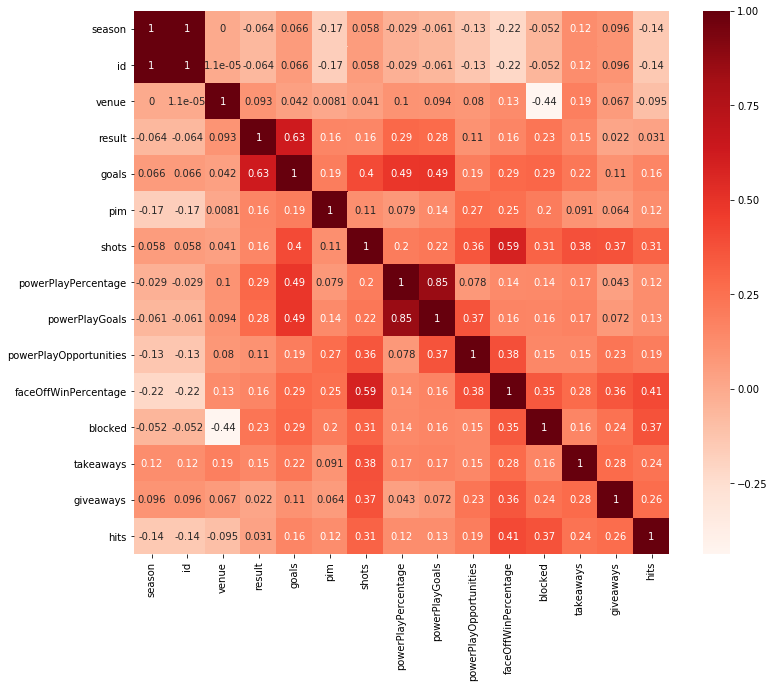

In [3]:
team_names, team_ids = get_teams()

data = pd.read_sql_table(team_names[0], conn)
data.loc[:,'venue'] = data.loc[:,'venue'].map({'home': 1, 'away': 0}) #integer encode venue 
data.loc[:,'result'] = data.loc[:,'result'].map({'win': 1, 'loss': 0}) #map to binary for classification 
plt.figure(figsize=(12,10))
corr = data.corr()
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
plt.show()

Goals is the most correlated feature with result. This makes sense on an intuitive level, since more goals scored should equate to higher chance of winning.

powerPlayPercentage and powerPlayGoals are very highly correlated, which makes sense. We're going to remove powerPlayPercentage then.

shots and faceOffWinPercentage are also pretty correlated, but leave them for now. faceOffWinPercentage are a good indicator of offensive possession. 

Defined 53 models
>0logistic: 0.809 (+/-0.063)
>1logistic: 0.821 (+/-0.068)
>2logistic: 0.797 (+/-0.068)
>3logistic: 0.797 (+/-0.068)
>0ridge-0.1: 0.813 (+/-0.068)
>1ridge-0.1: 0.813 (+/-0.068)
>2ridge-0.1: 0.813 (+/-0.068)
>3ridge-0.1: 0.813 (+/-0.068)
>0ridge-0.2: 0.813 (+/-0.068)
>1ridge-0.2: 0.813 (+/-0.068)
>2ridge-0.2: 0.809 (+/-0.068)
>3ridge-0.2: 0.809 (+/-0.068)
>0ridge-0.3: 0.813 (+/-0.068)
>1ridge-0.3: 0.813 (+/-0.068)
>2ridge-0.3: 0.809 (+/-0.068)
>3ridge-0.3: 0.809 (+/-0.068)
>0ridge-0.4: 0.813 (+/-0.068)
>1ridge-0.4: 0.813 (+/-0.068)
>2ridge-0.4: 0.809 (+/-0.068)
>3ridge-0.4: 0.809 (+/-0.068)
>0ridge-0.5: 0.813 (+/-0.068)
>1ridge-0.5: 0.813 (+/-0.068)
>2ridge-0.5: 0.809 (+/-0.068)
>3ridge-0.5: 0.809 (+/-0.068)
>0ridge-0.6: 0.813 (+/-0.068)
>1ridge-0.6: 0.813 (+/-0.068)
>2ridge-0.6: 0.813 (+/-0.066)
>3ridge-0.6: 0.813 (+/-0.066)
>0ridge-0.7: 0.813 (+/-0.068)
>1ridge-0.7: 0.813 (+/-0.068)
>2ridge-0.7: 0.813 (+/-0.066)
>3ridge-0.7: 0.813 (+/-0.066)
>0ridge-0.8: 0.813 (+/-0.0

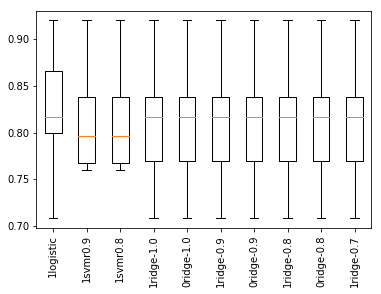

In [99]:
data = pd.read_sql_table("Chicago Blackhawks", conn) 

feature_cols = ['season', 'venue', 'goals', 'powerPlayGoals', 'powerPlayOpportunities', 'faceOffWinPercentage', 
                'shots', 'blocked', 'takeaways', 'giveaways', 'hits'] 

X = data[feature_cols] 
X.loc[:,'venue'] = X.loc[:,'venue'].map({'home': 1, 'away': 0}) #integer encode venue 
y = data.loc[:,['result', 'season', 'shots']] #include shots to keep track of current games played 
y.loc[:,'result'] = y.loc[:,'result'].map({'win': 1, 'loss': 0}) #map to binary for classification 

# Split into test and train data. Use 3 previous seasons for training data (2015/2016, 2016/2017, 2017/2018). 
# Use current season as test data. 
X_train, X_test = X.loc[X['season'] < 2018], X.loc[(X['season'] == 2018) & (X['shots'] > 0)] 
X_train, X_test = X_train.drop(columns=['season']), X_test.drop(columns=['season']) 

y_train, y_test = y.loc[y['season'] < 2018], y.loc[(y['season'] == 2018) & (y['shots'] > 0)] 
y_train, y_test = y_train.drop(columns=['season', 'shots']), y_test.drop(columns=['season', 'shots'])

models = bc.define_models()
pipelines = [bc.pipeline_none, bc.pipeline_standardize, bc.pipeline_normalize, bc.pipeline_std_norm]
results = bc.evaluate_models(X_train, y_train, models, pipelines)
bc.summarize_results(results)

Spot checking Blackhawks training data shows linear models do the best. For the Ridge Classifier, the values chosen for alpha do not impact results. The top 5 models seem to be Logistic Regression, Ridge Classifier, SVC (with linear & rbf kernels and C values around 0.9), and Gaussian Naive Bayes with standardized features. 

In [162]:
from binary_classifier import pipeline_standardize
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [177]:
accuracies = []

In [146]:
good_models = {}
good_models['logistic'] = {'pipe': pipeline_standardize(models['logistic']), 
                           'params': {'model__C': np.logspace(-4, 4, 20)}}
good_models['ridge'] = {'pipe': pipeline_standardize(models['ridge-1.0']), 
                        'params': {'model__alpha': np.logspace(-4, 4, 20)}}
good_models['svml'] = {'pipe': pipeline_standardize(models['svml']),
                      'params': {'model__C': np.logspace(-4, 4, 10)}}
good_models['svmr'] = {'pipe': pipeline_standardize(SVC(kernel='rbf')),
                      'params': {'model__C': np.logspace(-4, 4, 20), 'model__gamma': np.logspace(-3, 2, 6)}}
good_models['bayes'] = {'pipe': pipeline_standardize(SVC(kernel='rbf')),
                      'params': {}} #Naive_bayes doesn't have any parameters to tune

In [184]:
for team in team_names:
    data = pd.read_sql_table(team, conn) 

    feature_cols = ['season', 'venue', 'goals', 'powerPlayGoals', 'powerPlayOpportunities', 'faceOffWinPercentage', 
                'shots', 'blocked', 'takeaways', 'giveaways', 'hits'] 

    X = data[feature_cols] 
    X.loc[:,'venue'] = X.loc[:,'venue'].map({'home': 1, 'away': 0}) #integer encode venue 
    y = data.loc[:,['result', 'season', 'shots']] #include shots to keep track of current games played 
    y.loc[:,'result'] = y.loc[:,'result'].map({'win': 1, 'loss': 0}) #map to binary for classification 

    # Split into test and train data. Use 3 previous seasons for training data (2015/2016, 2016/2017, 2017/2018). 
    # Use current season as test data. 
    X_train, X_test = X.loc[X['season'] < 2018], X.loc[(X['season'] == 2018) & (X['shots'] > 0)] 
    X_train, X_test = X_train.drop(columns=['season']), X_test.drop(columns=['season']) 

    y_train, y_test = y.loc[y['season'] < 2018], y.loc[(y['season'] == 2018) & (y['shots'] > 0)] 
    y_train, y_test = y_train.drop(columns=['season', 'shots']), y_test.drop(columns=['season', 'shots'])

    best_models = {}
    for k in good_models:
        inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
        outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

        clf = GridSearchCV(estimator=good_models[k]['pipe'], param_grid=good_models[k]['params'], cv=inner_cv)
        scores = cross_val_score(clf, X=X_train, y=y_train, cv=outer_cv)
        #print(scores)
        #print(scores.mean())
        cv_scores[k] = scores.mean()

    #Choose best 3 models
    sorted_scores = sorted(cv_scores.items(), key=lambda v: v[1], reverse=True)
    for i in range(0,3):
        best_models[sorted_scores[i][0]] = good_models[sorted_scores[i][0]]

    best_acc = 0.
    best_model = 'blah'
    for i in best_models:
        clf = GridSearchCV(estimator=best_models[i]['pipe'], param_grid=best_models[i]['params'], cv=10)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        if accuracy_score(y_test,y_pred) > best_acc:
            best_acc = accuracy_score(y_test,y_pred)
            best_model = type(best_models[i]['pipe'].steps[1][1]).__name__

    accuracies.append(best_acc)
    print(team + ' with model ' + best_model + ' achieved accuracy: ' + '{0:.3f}'.format(best_acc))

New Jersey Devils with model RidgeClassifier achieved accuracy: 0.803
New York Islanders with model SVC achieved accuracy: 0.859
New York Rangers with model SVC achieved accuracy: 0.703
Philadelphia Flyers with model LogisticRegression achieved accuracy: 0.862
Pittsburgh Penguins with model LogisticRegression achieved accuracy: 0.769
Boston Bruins with model SVC achieved accuracy: 0.754
Buffalo Sabres with model RidgeClassifier achieved accuracy: 0.831
Montréal Canadiens with model LogisticRegression achieved accuracy: 0.864
Ottawa Senators with model SVC achieved accuracy: 0.692
Toronto Maple Leafs with model SVC achieved accuracy: 0.923
Carolina Hurricanes with model RidgeClassifier achieved accuracy: 0.892
Florida Panthers with model LogisticRegression achieved accuracy: 0.734
Tampa Bay Lightning with model SVC achieved accuracy: 0.848
Washington Capitals with model RidgeClassifier achieved accuracy: 0.800
Chicago Blackhawks with model SVC achieved accuracy: 0.708
Detroit Red Wings 

<BarContainer object of 31 artists>

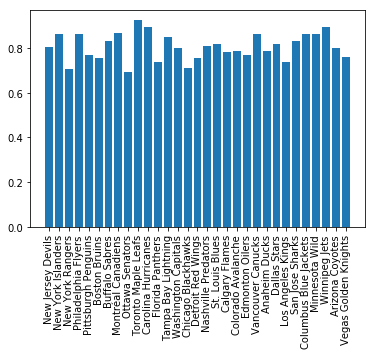

In [206]:
plt.xticks(rotation='vertical')
plt.bar(team_names, accuracies)

In [209]:
print('Average accuracy across all teams: ' + str(np.mean(accuracies)))

Average accuracy across all teams: 0.8048387096774192
